In [1]:
import matplotlib.pyplot as plt

# LOAD DATASET
from util.data_loader import load_dataset
x_train, y_train, x_test, feature_names = load_dataset(path_x_train="data/dataset/x_train.csv",
                                                       path_y_train="data/dataset/y_train.csv",
                                                       path_x_test="data/dataset/x_test.csv",
                                                       sub_sample=False)

In [2]:
# REMOVE USELESS FEATURES
from util.features_info import FEATURES_DICT
from util.features_util import keep_features
feature_indexes = dict(zip(feature_names, range(len(feature_names))))
x_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes)

Kept 76 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', '_HCVU651', '_CHOLCHK', '_RFCHOL', 'CVDSTRK3', '_ASTHMS1', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', '_DRDXAR1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', '_AGE80', 'MARITAL', '_CHLDCNT', '_EDUCAG', '_INCOMG', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HTM4', 'WTKG3', '_BMI5', '_SMOKER3', 'USENOW3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', '_DRNKWEK', '_RFDRHV5', 'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', '_FRUTSUM', '_VEGESUM', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'METVL11_', 'METVL21_', 'MAXVO2_', 'ACTIN11_', 'ACTIN21_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC11', '_MINAC21', 'STRFREQ_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1', '_PAINDX1', '_PA150R2', '_PA300R2', '_PA30021', '_PASTRNG'])


In [3]:
# PREPROCESS KEPT FEATURES
import numpy as np
from util.features_info import REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline
x_preprocessed = preprocessing_pipeline(x_clean, where=clean_features, feature_index=clean_feature_index,
                                        nan_replacement=REPLACEMENT_LIST)

C:\Users\anton\anaconda3\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [4]:
# oversample
from util.data_loader import custom_random_oversampling
x_oversampled, y_oversampled = custom_random_oversampling(x_preprocessed, y_train[:,1])

In [5]:
# Train a model
from util.data_loader import split_train_validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_oversampled, y_oversampled, valid_proportion=0.2)

In [8]:
import numpy as np

def min_max_normalize(arr: np.ndarray):
    arr_normalized = np.empty_like(arr)
    for column in range(arr.shape[1]):
        arr_normalized[:, column] = (arr[:, column] - arr[:, column].min()) / (arr[:, column].max() - arr[:, column].min())
    return arr_normalized

In [9]:
x_tr_normalized = min_max_normalize(x_tr)
# add final bias column
x_tr_normalized = np.append(x_tr_normalized, np.ones(shape=(x_tr_normalized.shape[0], 1)), axis=1)
x_va_normalized = min_max_normalize(x_va)
# add final bias column
x_va_normalized = np.append(x_va_normalized, np.ones(shape=(x_va_normalized.shape[0], 1)), axis=1)


In [28]:
from util.train import reg_logistic_regression
import numpy as np
w, train_loss, valid_loss = reg_logistic_regression(x_tr_normalized, y_tr, 
                                                    x_va_normalized, y_va, lambda_=0.001, 
                                                    max_iter=5000, gamma=0.01, batch_size=100, 
                                                    w=np.random.random(size=x_tr_normalized.shape[1]))

100%|██████████| 5000/5000 [02:18<00:00, 36.18it/s]


In [19]:
train_loss

[8.03170711747972,
 8.030904102752471,
 6.862936139416158,
 5.696826388135401,
 5.696326291431507,
 5.695825575495131,
 4.533292129025821,
 4.5333382046889925,
 4.533349459676053,
 4.533402563274317,
 4.533408918297775,
 3.3638459203240227,
 2.2217619505518273,
 1.2540451698326707,
 1.3690871249255898,
 1.4681911955084372,
 1.5520017228949667,
 0.8830589881934536,
 1.033490605136984,
 1.1712974711349788,
 0.7873718926970161,
 0.9036395667157194,
 1.0536894584971694,
 0.7690773541246073,
 0.8454743833843907,
 0.9669898923123448,
 0.7586682963283126,
 0.8439209637330127,
 0.768709440553834,
 0.795817238230695,
 0.9377892100992694,
 1.079188736324375,
 0.740751255787336,
 0.8459512712126424,
 0.7451793628054333,
 0.8535695846047212,
 0.7285374564105576,
 0.7839017327440598,
 0.9061586698080029,
 0.7158107714651474,
 0.7893045083461288,
 0.7249041348534092,
 0.8450597854966513,
 0.7120232303581211,
 0.811690405484511,
 0.9272518160688068,
 0.6964440003398741,
 0.7792944363083829,
 0.702750

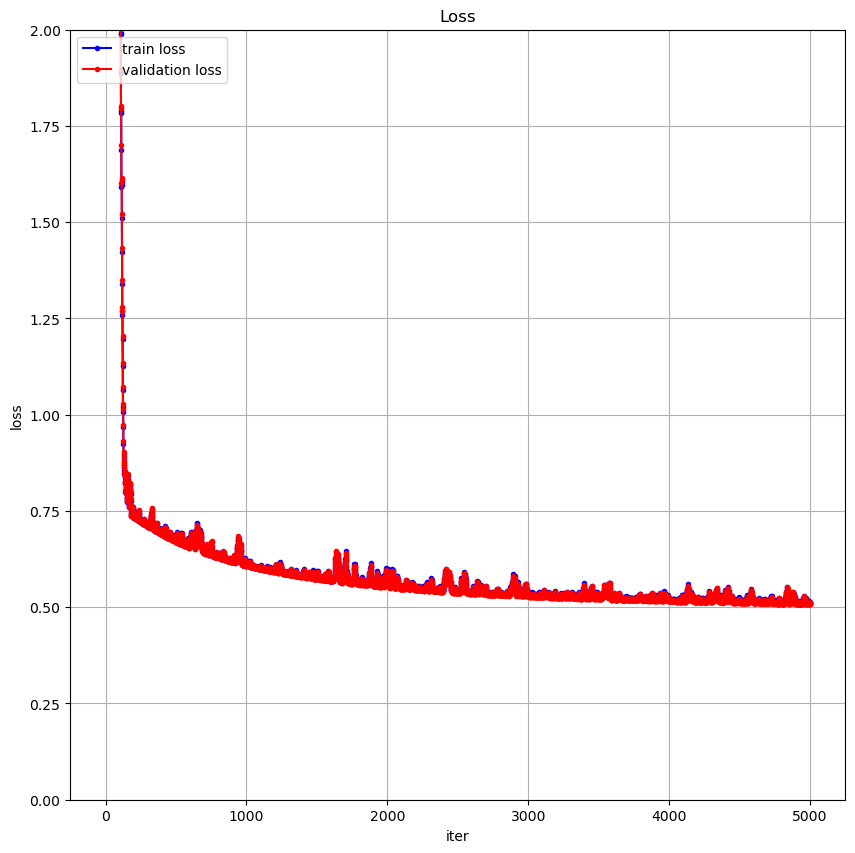

In [30]:
# plot losses
import matplotlib.pyplot as plt
from util.plotting import loss_visualization
plt.figure(figsize=(10, 10))
plt.ylim(0,2)
loss_visualization(train_loss, valid_loss)

In [31]:
from implementations import sigmoid
from util.evaluation import evaluation_summary
x_tr_predictions = np.where(sigmoid(x_tr_normalized @ w) >= 0.5, 1, -1)

evaluation_summary(y_tr, x_tr_predictions)

Accuracy: 75.71%
Precision: 74.33%
Recall: 77.32%
F1-score: 75.79%


(array([40699., 56888., 47002., 43352., 44248., 46915., 50187., 53272.,
        55726., 32839.]),
 array([0.01341482, 0.11167286, 0.2099309 , 0.30818894, 0.40644698,
        0.50470502, 0.60296306, 0.7012211 , 0.79947914, 0.89773718,
        0.99599522]),
 <BarContainer object of 10 artists>)

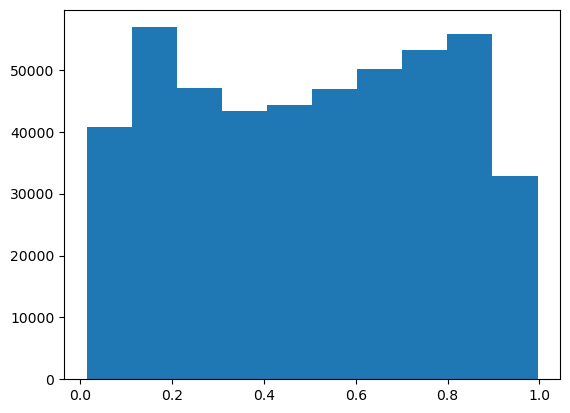

In [33]:
plt.hist(sigmoid(x_tr_normalized @ w))

In [53]:
np.isnan(x_tr_predictions).any()

False

In [42]:
x_preprocessed_norm = min_max_normalize(x_preprocessed)
# add final bias column
x_preprocessed_norm = np.append(x_preprocessed_norm, np.ones(shape=(x_preprocessed_norm.shape[0], 1)), axis=1)
x_complete_predictions = np.where(sigmoid(x_preprocessed_norm @ w) >= 0.75, 1, -1)

evaluation_summary(y_train[:,1], x_complete_predictions)

Accuracy: 87.77%
Precision: 34.25%
Recall: 41.87%
F1-score: 37.68%


(array([49487., 65084., 47205., 37187., 31174., 27341., 24241., 21323.,
        17460.,  7633.]),
 array([0.01337393, 0.11163463, 0.20989533, 0.30815604, 0.40641674,
        0.50467744, 0.60293814, 0.70119884, 0.79945954, 0.89772024,
        0.99598094]),
 <BarContainer object of 10 artists>)

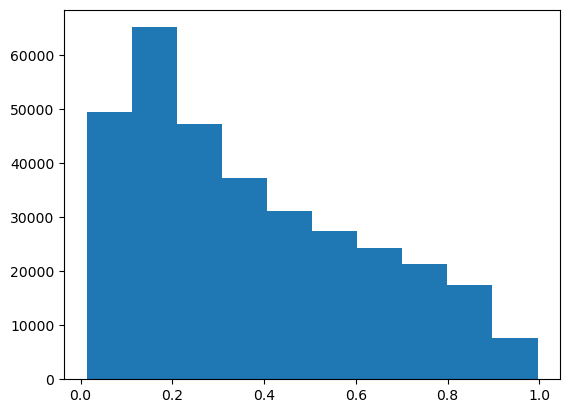

In [36]:
plt.hist(sigmoid(x_preprocessed_norm @ w))

In [44]:
x_test_normalized = min_max_normalize(x_test)
# add final bias column
x_test_normalized = np.append(x_test_normalized, np.ones(shape=(x_test_normalized.shape[0], 1)), axis=1)

x_test_predictions = np.where(sigmoid(x_test_normalized @ w) >= 0.7, 1, -1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 77 is different from 323)